In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import os
import joblib
import pickle
import mlflow.sklearn

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
df = pd.read_csv(r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\df.csv", sep=",")

# Limpieza del dataset. Tratamiento de Valores nulos

In [6]:
# Eliminamos filas que no pertenecen a Madrid Capital 
df = df[~df['distrito'].isin(['Ciudalcampo', 'La Moraleja'])]

In [7]:
# Eliminar 17 Columnas
columns_to_drop = ['Unnamed: 0', 'origin_id', 'construction_year', 'first_appearance', 'last_appearance', 'is_exact_address','is_vertical','n_floor', 'has_storage', 'has_garage_included', 'has_common_zones', 'has_terrace', 'has_air_conditioner', 'cardinal_direction_id','has_racket_zone','has_security','direccion']
df1 = df.drop(columns=columns_to_drop)

In [8]:
# Limpieza de barrios y calles en la columna "distritos"
mapeo_distritos = {
    "Universidad": "Centro",
    "Justicia": "Centro",
    "Distrito Municipal I (sin urbanizaciones)": "Centro",
    "Calle de Rejas": "Barajas",
    "Plaza de los Emperadores": "Barajas",
    "Colina": "Ciudad Lineal",
    "Casa de Campo": "Moncloa-Aravaca",
    "Ciudad Jardín": "Chamartín",
    "Campamento": "Latina",
    "Bellas Vistas": "Tetuán",
    "Valdefuentes": "Hortaleza",
    "Trafalgar": "Chamberí",
    "Mirasierra": "Fuencarral-El Pardo"
}
df1['distrito'] = df1['distrito'].map(mapeo_distritos).fillna(df1['distrito'])
print(df1['distrito'].unique())

['Chamberí' 'Chamartín' 'Tetuán' 'Retiro' 'Hortaleza' 'Salamanca' 'Centro'
 'Arganzuela' 'Moncloa-Aravaca' 'Latina' 'Villa de Vallecas' 'Barajas'
 'Ciudad Lineal' 'Vicálvaro' 'Puente de Vallecas' 'Fuencarral-El Pardo'
 'Carabanchel' 'Usera' 'San Blas - Canillejas' 'Villaverde' 'Moratalaz']


In [9]:
# Imputación de valores erróneos en la columna "local_price"
df1[df1['local_price'] == 0]

,area,local_price,replace,replace.1,tipology,description,title,url,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior,distrito
1278,120,0,40.400146,-3.673077,Piso,NaN,NaN,https://www.idealista.com/inmueble/81468436,1.0,1.0,NaN,NaN,t,t,Retiro
1569,75,0,40.448269,-3.649879,Piso,NaN,NaN,https://www.idealista.com/inmueble/81555931,2.0,1.0,t,NaN,t,t,Ciudad Lineal
2118,50,0,40.473816,-3.581212,Piso,NaN,NaN,https://www.idealista.com/inmueble/39712472,1.0,1.0,t,NaN,t,t,Barajas


In [10]:
df1.at[1278, 'local_price'] = 1800
df1.at[1569, 'local_price'] = 1250
df1.at[2118, 'local_price'] = 800

In [11]:
len(df1[df1['local_price'] > 7000])

172

In [12]:
def imputar_n_rooms(row):
    if pd.notna(row['n_rooms']):
        return row['n_rooms']
    elif pd.notna(row['description']):
        description = row['description'].lower()
        if 'estudio' in description or 'loft' in description or 'sin divisiones' in description:
            return 0
    return None

df1['n_rooms'] = df1.apply(imputar_n_rooms, axis=1)

In [13]:
df1['n_rooms'].fillna(1, inplace=True)

In [14]:
valores_a_eliminar = [9.0, 10.0, 15.0, 22.0]
df1 = df1[~df1['n_rooms'].isin(valores_a_eliminar)]

In [15]:
df1['n_baths'].fillna(1, inplace=True)

In [16]:
reemplazos = {0.0: 2.0, 20.0: 2.0, 22.0: 2.0, 55.0: 1.0}
df1['n_baths'].replace(reemplazos, inplace=True)

In [17]:
valores_a_eliminar = [10.0, 11.0, 13.0]
df1 = df1[~df1['n_baths'].isin(valores_a_eliminar)]

In [18]:
valores_a_eliminar = [635, 650, 680, 690, 720, 750, 758, 965, 1000, 1024, 1100, 1150, 1200, 1203, 2800, 7840]
df1 = df1[~df1['area'].isin(valores_a_eliminar)]

In [19]:
keywords = ['garaje', 'garage', 'plaza de parking', 'parking']
condition = df1['description'].str.contains('|'.join(keywords), case=False)
df1['has_garage'] = condition.apply(lambda x: 't' if x else 'f')

In [20]:
df1.loc[df1['tipology'] == 'chalet', 'has_garage'] = 't'

In [21]:
keywords = ['piscina', 'tiene piscina', 'dispone de piscina']
condition = df1['description'].str.contains('|'.join(keywords), case=False)
df1['has_pool'] = np.where(condition, 't', 'f')

In [22]:
condition = (df1['has_elevator'].isnull()) & (df1['description'].str.contains('con ascensor|tiene ascensor', case=False, na=False))
df1.loc[condition, 'has_elevator'] = 't'
condition = (df1['has_elevator'].isnull())
df1.loc[condition, 'has_elevator'] = 'f'

In [23]:
condition = (df1['is_exterior'].isnull()) & (df1['description'].str.contains('exterior|con terraza', case=False, na=False))
df1.loc[condition, 'is_exterior'] = 't'
condition = (df1['is_exterior'].isnull())
df1.loc[condition, 'is_exterior'] = 'f'

In [24]:
df1 = df1.drop(["description", "title", "url"], axis=1)

In [25]:
df1.rename(columns={'replace': 'latitud', 'replace.1': 'longitud'}, inplace=True)

In [26]:
df1

,area,local_price,latitud,longitud,tipology,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior,distrito
0,135,3200,40.437687,-3.691055,Piso,1.0,2.0,f,f,t,t,Chamberí
1,250,6000,40.439434,-3.686233,Piso,4.0,4.0,t,t,t,t,Chamartín
2,146,2460,40.468037,-3.708661,Piso,3.0,2.0,t,t,t,t,Tetuán
3,98,3000,40.441212,-3.670406,Piso,3.0,3.0,f,f,f,t,Chamartín
4,125,3675,40.411247,-3.668222,Piso,3.0,2.0,t,t,t,t,Retiro
...,...,...,...,...,...,...,...,...,...,...,...,...
6357,45,1450,40.414158,-3.701161,Piso,2.0,1.0,f,f,f,f,Centro
6358,30,1250,40.425045,-3.705386,Piso,2.0,1.0,f,f,f,f,Centro
6359,73,900,40.392933,-3.736926,Piso,3.0,1.0,t,t,t,t,Carabanchel
6360,32,850,40.417221,-3.703297,Piso,0.0,1.0,f,f,t,t,Centro


In [27]:
import os
carpeta_mis_documentos = r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES"
if not os.path.exists(carpeta_mis_documentos):
    os.makedirs(carpeta_mis_documentos)
ruta_guardado = os.path.join(carpeta_mis_documentos, "dflimpiohalloween.csv")
df1.to_csv(ruta_guardado, index=False)
print(f"El archivo CSV se ha guardado en: {ruta_guardado}")

El archivo CSV se ha guardado en: C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\dflimpiohalloween.csv


# Transformaciones

In [28]:
le = LabelEncoder()
df1['tipology'] = le.fit_transform(df1['tipology'])

In [29]:
le = LabelEncoder()
df1['has_garage'] = le.fit_transform(df1['has_garage'])

In [30]:
le = LabelEncoder()
df1['has_pool'] = le.fit_transform(df1['has_pool'])

In [31]:
le = LabelEncoder()
df1['has_elevator'] = le.fit_transform(df1['has_elevator'])

In [32]:
le = LabelEncoder()
df1['is_exterior'] = le.fit_transform(df1['is_exterior'])

# EDA

In [33]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6330 entries, 0 to 6361
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area          6330 non-null   int64  
 1   local_price   6330 non-null   int64  
 2   latitud       6330 non-null   float64
 3   longitud      6330 non-null   float64
 4   tipology      6330 non-null   int32  
 5   n_rooms       6330 non-null   float64
 6   n_baths       6330 non-null   float64
 7   has_garage    6330 non-null   int32  
 8   has_pool      6330 non-null   int32  
 9   has_elevator  6330 non-null   int32  
 10  is_exterior   6330 non-null   int32  
 11  distrito      6330 non-null   object 
dtypes: float64(4), int32(5), int64(2), object(1)
memory usage: 519.3+ KB


In [34]:
df1.describe()

,area,local_price,latitud,longitud,tipology,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior
count,6330.000000,6330.000000,6330.000000,6330.000000,6330.000000,6330.000000,6330.000000,6330.000000,6330.000000,6330.000000,6330.000000
mean,107.489258,2309.824013,40.431495,-3.686762,0.977883,2.180569,1.775987,0.322907,0.234439,0.808847,0.841706
std,76.212949,1727.071316,0.029298,0.033224,0.147075,1.200319,1.009541,0.467624,0.423681,0.393241,0.365045
min,17.000000,400.000000,40.332451,-3.832705,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,1200.000000,40.414404,-3.704209,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,85.000000,1800.000000,40.429073,-3.691760,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000
75%,130.000000,2850.000000,40.450004,-3.674365,1.000000,3.000000,2.000000,1.000000,0.000000,1.000000,1.000000
max,600.000000,20000.000000,40.520374,-3.528354,1.000000,8.000000,8.000000,1.000000,1.000000,1.000000,1.000000


# Variable: "area"

In [35]:
unique_values = df1['area'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['area'].nunique()
area_counts = df1['area'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'area':", unique_values_count)
print(area_counts)

Valores únicos: [17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 224, 225, 227, 228, 229, 230, 231, 232, 233, 

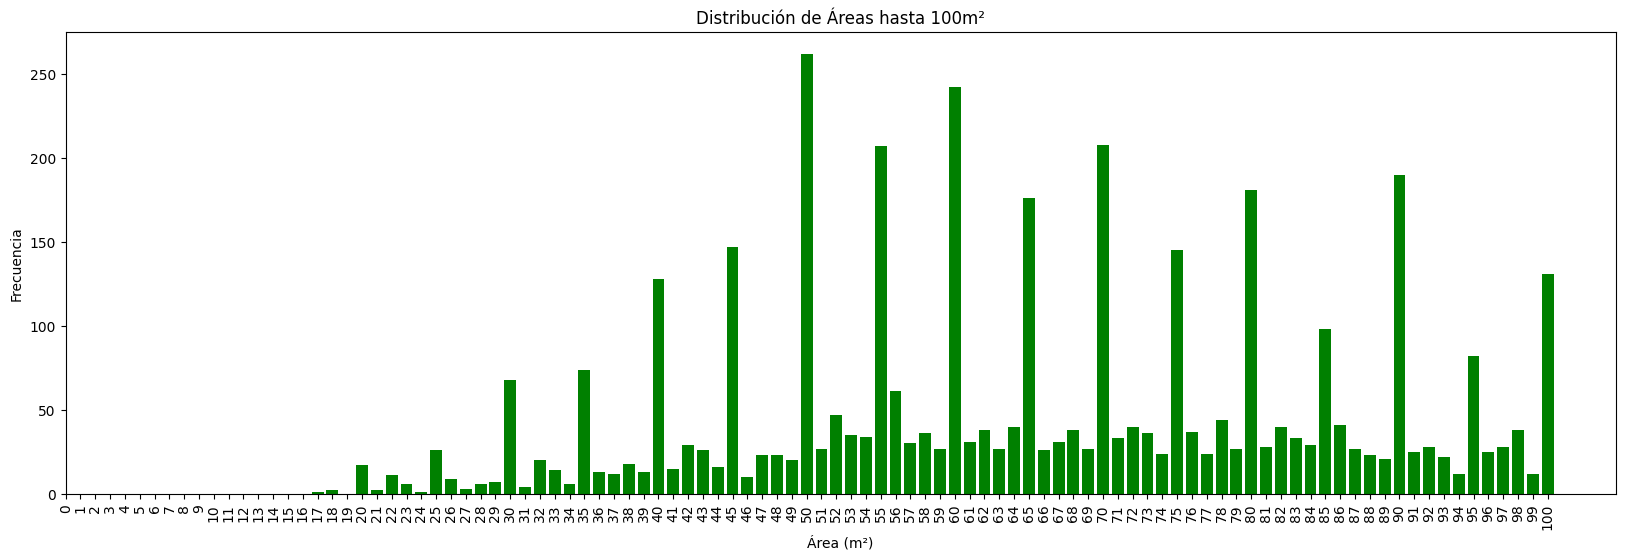

In [36]:
df_areas_hasta_100 = df1[df1['area'] <= 100]
frecuencia_areas = df_areas_hasta_100['area'].value_counts().sort_index()
plt.figure(figsize=(20, 6))
plt.bar(frecuencia_areas.index, frecuencia_areas.values, color='green')
plt.xlabel('Área (m²)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Áreas hasta 100m²')
plt.xticks(range(101), rotation=90)
plt.show()

# Variable: "local_price"

In [37]:
unique_values = df1['local_price'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['local_price'].nunique()
local_price_counts = df1['local_price'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'local_price':", unique_values_count)
print(local_price_counts)

Valores únicos: [400, 490, 499, 500, 530, 549, 550, 575, 580, 590, 595, 600, 608, 620, 625, 630, 645, 649, 650, 665, 670, 675, 680, 690, 695, 699, 700, 710, 720, 725, 730, 740, 749, 750, 752, 760, 761, 764, 765, 768, 770, 775, 780, 785, 790, 795, 799, 800, 805, 810, 811, 820, 825, 829, 830, 840, 845, 849, 850, 853, 855, 860, 870, 874, 875, 877, 880, 883, 890, 895, 899, 900, 904, 906, 910, 915, 917, 920, 925, 930, 935, 937, 940, 941, 945, 947, 950, 955, 960, 966, 970, 975, 980, 982, 984, 985, 990, 995, 999, 1000, 1004, 1005, 1010, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1060, 1065, 1066, 1070, 1075, 1080, 1085, 1090, 1095, 1100, 1107, 1108, 1110, 1120, 1122, 1125, 1130, 1134, 1135, 1145, 1149, 1150, 1160, 1165, 1170, 1175, 1180, 1185, 1190, 1194, 1195, 1199, 1200, 1210, 1220, 1221, 1225, 1230, 1235, 1240, 1245, 1249, 1250, 1252, 1260, 1261, 1265, 1270, 1275, 1280, 1285, 1289, 1290, 1295, 1299, 1300, 1310, 1320, 1325, 1329, 1347, 1350, 1351, 1357, 1360, 1365, 1370, 1375, 1377, 13

In [38]:
df1[df1['local_price'] == 20000]


,area,local_price,latitud,longitud,tipology,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior,distrito
5084,462,20000,40.437447,-3.690439,1,4.0,5.0,1,0,1,1,Chamberí
5087,277,20000,40.434418,-3.687745,1,4.0,5.0,1,0,1,1,Salamanca


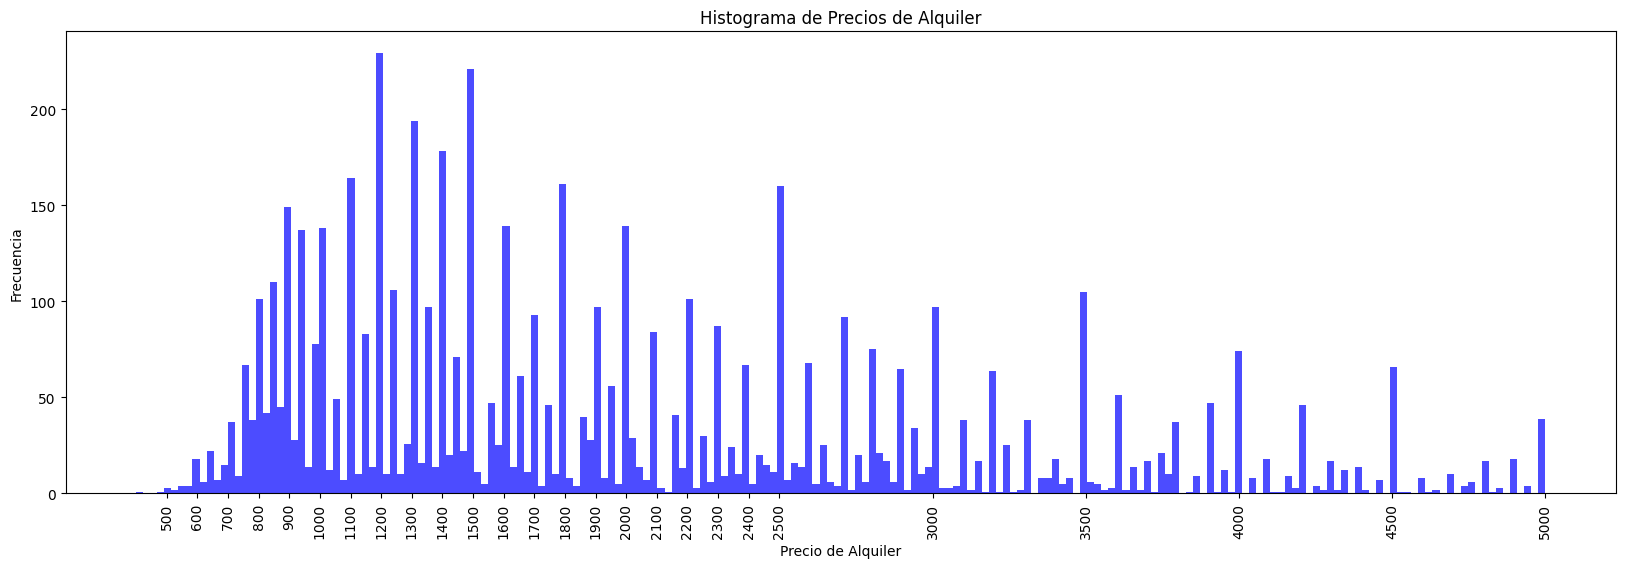

In [39]:
import matplotlib.pyplot as plt
local_prices_filtered = df1[df1['local_price'] <= 5000]['local_price']
plt.figure(figsize=(20, 6))
plt.hist(local_prices_filtered, bins=200, color='blue', alpha=0.7)
x_ticks = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 3000, 3500, 4000, 4500, 5000]
x_labels = [str(x) for x in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=90)
plt.xlabel('Precio de Alquiler')
plt.ylabel('Frecuencia')
plt.title('Histograma de Precios de Alquiler')
plt.show()

In [40]:
df1[df1['local_price'] == 0]

,area,local_price,latitud,longitud,tipology,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior,distrito


# Variable: "tipology"... (chalet / piso)

In [41]:
unique_values = df1['tipology'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['tipology'].nunique()
tipology_counts = df1['tipology'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'tipology':", unique_values_count)
print(tipology_counts)

Valores únicos: [0, 1]
Cantidad de valores únicos en la columna 'tipology': 2
tipology
1    6190
0     140
Name: count, dtype: int64


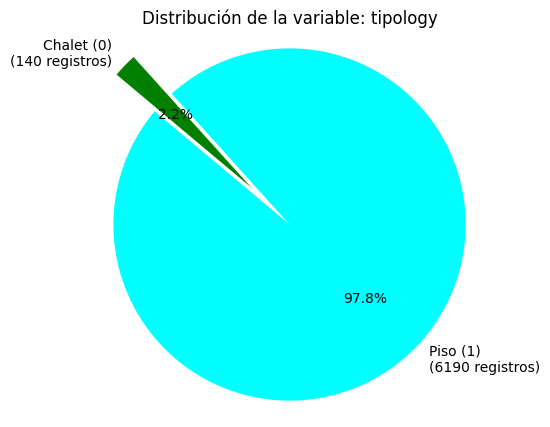

In [42]:
count_tipology = df1['tipology'].value_counts()
labels = ['Piso (1)', 'Chalet (0)']
colors = ['cyan', 'green']
count_records = [6190, 140]
explode = (0, 0.3)
plt.figure(figsize=(5, 5))
_, texts, _ = plt.pie(count_tipology, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
for i, text in enumerate(texts):
    text.set_text(f"{labels[i]}\n({count_records[i]} registros)")
plt.title('Distribución de la variable: tipology')
plt.axis('equal')
plt.show()

# Variable: "n_rooms"

In [43]:
unique_values = df1['n_rooms'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['n_rooms'].nunique()
n_rooms_counts = df1['n_rooms'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'n_rooms':", unique_values_count)
print(n_rooms_counts)

Valores únicos: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
Cantidad de valores únicos en la columna 'n_rooms': 9
n_rooms
2.0    2078
1.0    1729
3.0    1434
4.0     584
0.0     265
5.0     179
6.0      46
7.0      11
8.0       4
Name: count, dtype: int64


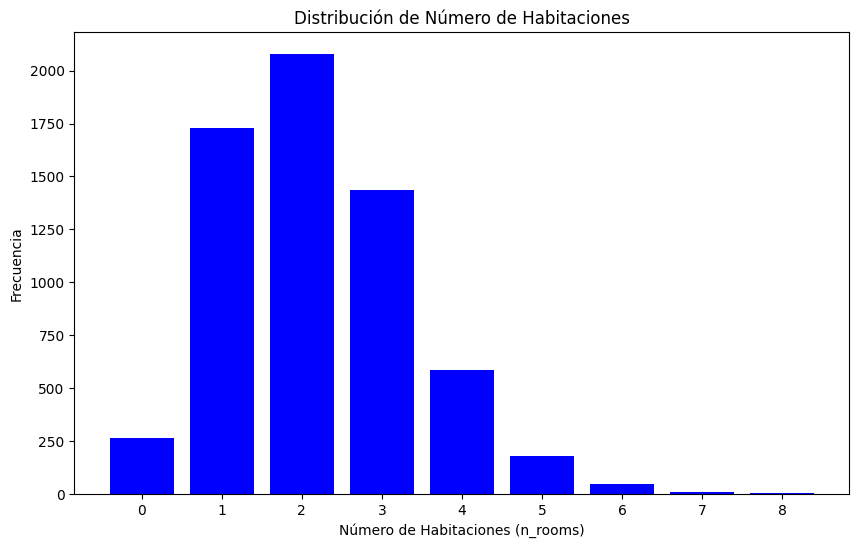

In [44]:
valores_x = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
frecuencia_n_rooms = df1['n_rooms'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.bar(frecuencia_n_rooms.index, frecuencia_n_rooms.values, color='blue')
plt.xlabel('Número de Habitaciones (n_rooms)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Número de Habitaciones')
plt.xticks(valores_x)
plt.show()

# Variable: "n_baths"

In [45]:
unique_values = df1['n_baths'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['n_baths'].nunique()
n_baths_counts = df1['n_baths'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'n_baths':", unique_values_count)
print(n_baths_counts)

Valores únicos: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
Cantidad de valores únicos en la columna 'n_baths': 8
n_baths
1.0    3160
2.0    2088
3.0     635
4.0     281
5.0     129
6.0      30
7.0       4
8.0       3
Name: count, dtype: int64


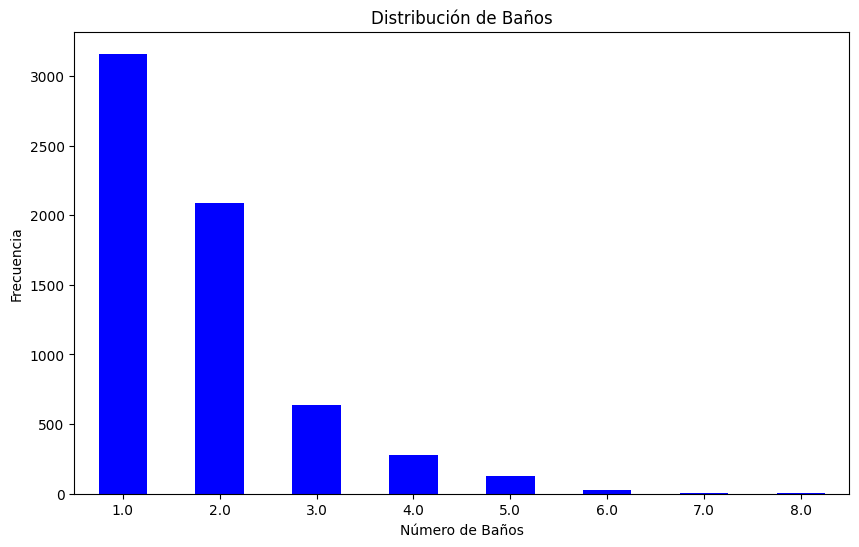

In [46]:
data = df1['n_baths'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
data.plot(kind='bar', color='blue')
plt.title('Distribución de Baños')
plt.xlabel('Número de Baños')
plt.ylabel('Frecuencia')
plt.xticks(rotation=0)
plt.show()

# Variable: "has_garage"

In [47]:
unique_values = df1['has_garage'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['has_garage'].nunique()
has_garage_counts = df1['has_garage'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'has_garage':", unique_values_count)
print(has_garage_counts)

Valores únicos: [0, 1]
Cantidad de valores únicos en la columna 'has_garage': 2
has_garage
0    4286
1    2044
Name: count, dtype: int64


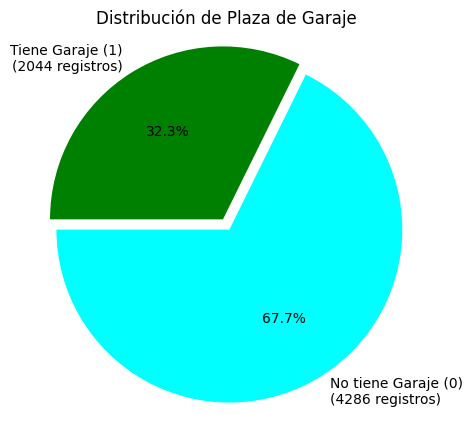

In [48]:
count_tipology = df1['has_garage'].value_counts()
labels = ['No tiene Garaje (0)', 'Tiene Garaje (1)']
colors = ['cyan', 'green']
count_records = [4286, 2044]
explode = (0, 0.07)
plt.figure(figsize=(5, 5))
_, texts, _ = plt.pie(count_tipology, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180, explode=explode)
for i, text in enumerate(texts):
    text.set_text(f"{labels[i]}\n({count_records[i]} registros)")
plt.title('Distribución de Plaza de Garaje')
plt.axis('equal')
plt.show()

# Variable: "has_pool"

In [49]:
unique_values = df1['has_pool'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['has_pool'].nunique()
has_pool_counts = df1['has_pool'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'has_pool':", unique_values_count)
print(has_pool_counts)

Valores únicos: [0, 1]
Cantidad de valores únicos en la columna 'has_pool': 2
has_pool
0    4846
1    1484
Name: count, dtype: int64


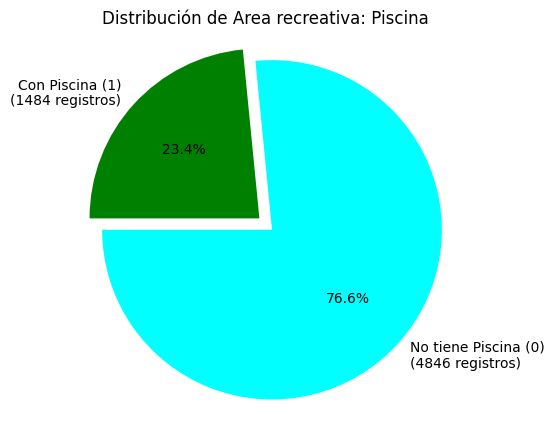

In [50]:
count_tipology = df1['has_pool'].value_counts()
labels = ['No tiene Piscina (0)', 'Con Piscina (1)']
colors = ['cyan', 'green']
count_records = [4846, 1484]
explode = (0, 0.1)
plt.figure(figsize=(5, 5))
_, texts, _ = plt.pie(count_tipology, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180, explode=explode)
for i, text in enumerate(texts):
    text.set_text(f"{labels[i]}\n({count_records[i]} registros)")
plt.title('Distribución de Area recreativa: Piscina')
plt.axis('equal')
plt.show()

# Variable: "has_elevator"

In [51]:
unique_values = df1['has_elevator'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['has_elevator'].nunique()
has_elevator_counts = df1['has_elevator'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'has_elevator':", unique_values_count)
print(has_elevator_counts)

Valores únicos: [0, 1]
Cantidad de valores únicos en la columna 'has_elevator': 2
has_elevator
1    5120
0    1210
Name: count, dtype: int64


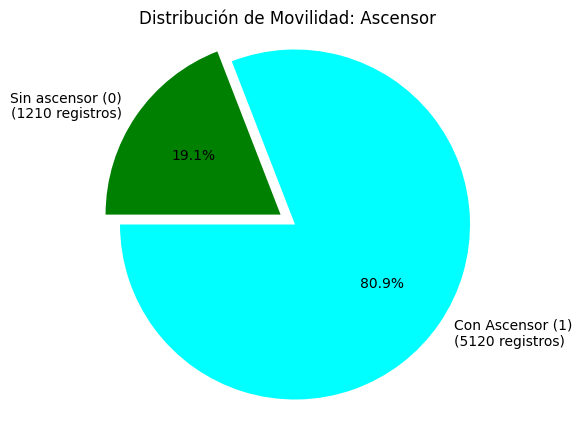

In [52]:
count_tipology = df1['has_elevator'].value_counts()
labels = ['Con Ascensor (1)', 'Sin ascensor (0)']
colors = ['cyan', 'green']
count_records = [5120, 1210]
explode = (0, 0.1)
plt.figure(figsize=(5, 5))
_, texts, _ = plt.pie(count_tipology, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180, explode=explode)
for i, text in enumerate(texts):
    text.set_text(f"{labels[i]}\n({count_records[i]} registros)")
plt.title('Distribución de Movilidad: Ascensor')
plt.axis('equal')
plt.show()

# Variable: "is_exterior"

In [53]:
unique_values = df1['is_exterior'].unique()
unique_values = sorted(unique_values)
unique_values_count = df1['is_exterior'].nunique()
is_exterior_counts = df1['is_exterior'].value_counts()

print("Valores únicos:", unique_values)
print("Cantidad de valores únicos en la columna 'is_exterior':", unique_values_count)
print(is_exterior_counts)

Valores únicos: [0, 1]
Cantidad de valores únicos en la columna 'is_exterior': 2
is_exterior
1    5328
0    1002
Name: count, dtype: int64


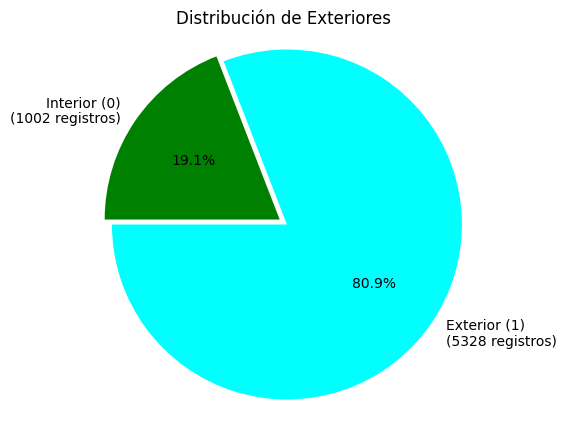

In [54]:
count_tipology = df1['has_elevator'].value_counts()
labels = ['Exterior (1)', 'Interior (0)']
colors = ['cyan', 'green']
count_records = [5328, 1002]
explode = (0, 0.05)
plt.figure(figsize=(5, 5))
_, texts, _ = plt.pie(count_tipology, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180, explode=explode)
for i, text in enumerate(texts):
    text.set_text(f"{labels[i]}\n({count_records[i]} registros)")
plt.title('Distribución de Exteriores')
plt.axis('equal')
plt.show()

In [55]:
plt.figure(figsize=(10,8))
sns.heatmap(matriz_correlacion,annot=True)

NameError: name 'matriz_correlacion' is not defined

<Figure size 1000x800 with 0 Axes>

# Estandarización (5 variables)

In [56]:
scaler = StandardScaler()
columns_to_scale = ['area', 'latitud', 'longitud', 'n_rooms', 'n_baths']
df1[columns_to_scale] = scaler.fit_transform(df1[columns_to_scale])

In [57]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [58]:
import pickle
from sklearn.preprocessing import StandardScaler

# Ajustar el StandardScaler a tus datos
scaler = StandardScaler().fit(df1[columns_to_scale])

# Guardar el objeto StandardScaler en un archivo pickle
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [59]:
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [60]:
scaler

StandardScaler()

In [61]:
from sklearn.preprocessing import StandardScaler
import pickle

scaler = StandardScaler()
columns_to_scale = ['area', 'latitud', 'longitud', 'n_rooms', 'n_baths']
scaler.fit(df1[columns_to_scale])

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [62]:
import os
carpeta_mis_documentos = r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES"
if not os.path.exists(carpeta_mis_documentos):
    os.makedirs(carpeta_mis_documentos)
ruta_guardado = os.path.join(carpeta_mis_documentos, "Valoración_Alquilereshalloween.csv")
df1.to_csv(ruta_guardado, index=False)
print(f"El archivo CSV se ha guardado en: {ruta_guardado}")

El archivo CSV se ha guardado en: C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\Valoración_Alquilereshalloween.csv


# ML (Modelos Predictivos de Regresión)

In [63]:
X = df1.drop('local_price', axis=1)  
y = df1['local_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)

In [ ]:
modeloRFR = RandomForestRegressor(n_estimators=100, random_state=1)
modeloRFR.fit(X_train, y_train)

ValueError: could not convert string to float: 'Ciudad Lineal'

In [ ]:
y_pred = modeloRFR.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f'Error Cuadrático Medio (MSE): {mse}')

Error Cuadrático Medio (MSE): 757026.5790891849


In [ ]:
r2 = r2_score(y_test, y_pred)
print(f'Coeficiente de Determinación (R^2): {r2}')

Coeficiente de Determinación (R^2): 0.7290993064844197


In [ ]:
importances = modeloRFR.feature_importances_
feature_names = df1.columns.drop("local_price")
print(feature_names)
print(importances)


Index(['area', 'latitud', 'longitud', 'tipology', 'n_rooms', 'n_baths',
       'has_garage', 'has_pool', 'has_elevator', 'is_exterior'],
      dtype='object')
[0.5951904  0.17915695 0.10199731 0.00096596 0.02234865 0.07427358
 0.00758685 0.00852815 0.00513563 0.00481651]


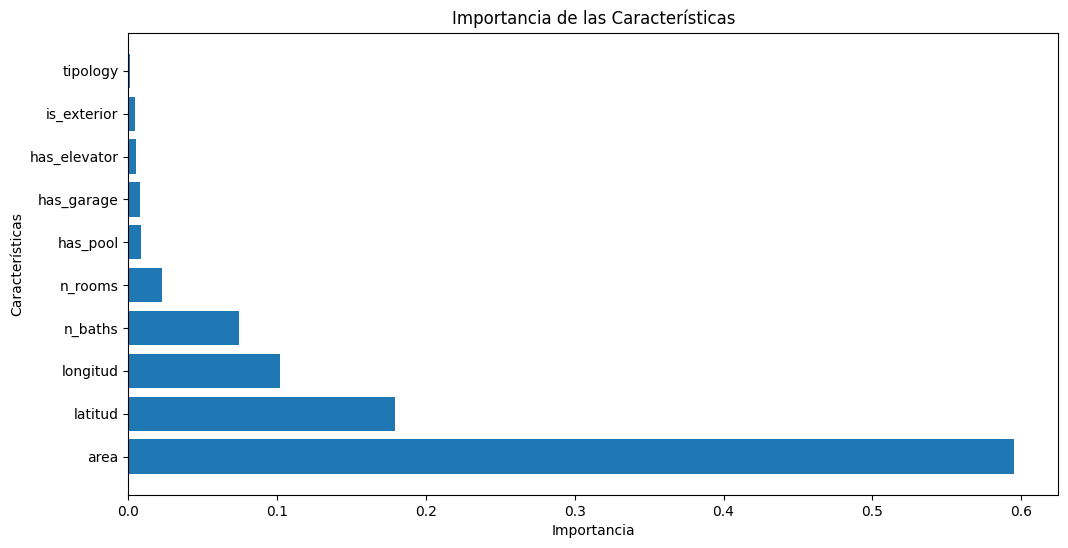

In [ ]:
importances = modeloRFR.feature_importances_
feature_names = df1.columns.drop("local_price")
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de las Características')
plt.show()

# Clusterización

In [ ]:
def clusters_optimo(df, variables, max_clusters=10):
    data = df[variables].values
    sse = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)
    plt.plot(range(1, max_clusters + 1), sse)
    plt.title('Método del Codo')
    plt.xlabel('Clusters')
    plt.ylabel('(SSE)')
    plt.show()
    clusters_mejor = np.argmin(np.diff(sse)) + 1
    print('mejor clusters {}'.format(clusters_mejor))
    return clusters_mejor

In [ ]:
def prueba_kmeans(df, variables, num_clusters):
    data = df[variables].values
    kmeans = KMeans(n_clusters=num_clusters)
    cluster = kmeans.fit_predict(data)
    return cluster

## KMeans en dataset codificado/escalado

In [ ]:
# Leer df (codificado/escalado) de data/
df=pd.read_csv(r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\Valoración_Alquilereshalloween.csv", sep=',')

In [ ]:
# renombrar columnas latitud longitud
df.rename(columns={'replace':'latitud', 'replace.1':'longitud'}, inplace=True)

In [ ]:
# columnas a pasar a funcion prueba_kmeans y clusters_optimo

col=['area', 'tipology', 'n_rooms',
       'n_baths', 'has_garage', 'has_pool', 'has_elevator', 'is_exterior']

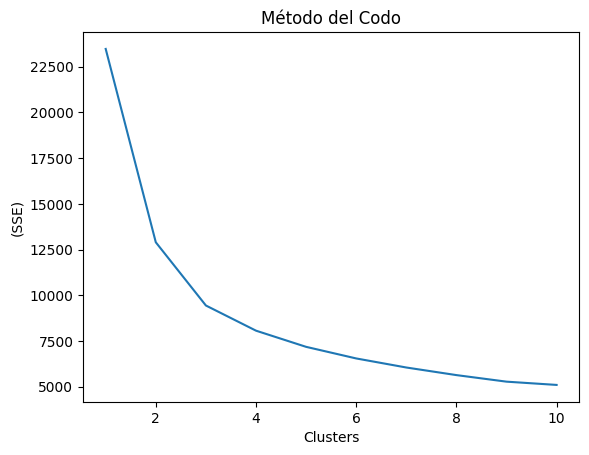

mejor clusters 1


1

In [ ]:
mejor_clusters=clusters_optimo(df, col)
mejor_clusters

In [ ]:
lista=[]

In [ ]:
for i in range(2,20):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(df[col])
    lista.append(kmeans.inertia_)

c:\Users\axa\miniconda3\envs\modeloml\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\axa\miniconda3\envs\modeloml\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\axa\miniconda3\envs\modeloml\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\axa\miniconda3\envs\modeloml\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` wi

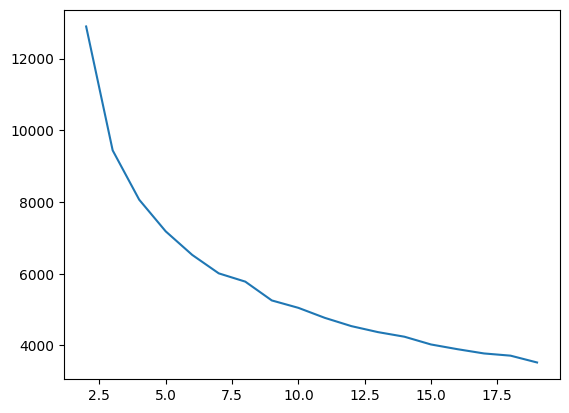

In [ ]:
plt.plot(range(2,20), lista)

In [ ]:
pred=prueba_kmeans(df, df.columns, 4)

c:\Users\axa\miniconda3\envs\modeloml\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# añadir columna cluster con la predicción
df['cluster']=pred

In [ ]:
df.columns

Index(['area', 'local_price', 'latitud', 'longitud', 'tipology', 'n_rooms',
       'n_baths', 'has_garage', 'has_pool', 'has_elevator', 'is_exterior',
       'cluster'],
      dtype='object')

In [ ]:
df.cluster.value_counts(normalize=True)

cluster
0    0.596840
3    0.302686
1    0.086098
2    0.014376
Name: proportion, dtype: float64

### df_limpio . Ver media/moda de cada variable

In [ ]:
# Leer df_limpio (sin codificar ni escalar) de data
df_limpio=pd.read_csv(r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\dflimpio.csv", sep=",")

In [ ]:
# renombrar columnas latitud longitud
df_limpio.rename(columns={'replace':'latitud', 'replace.1':'longitud'}, inplace=True)

In [ ]:
df_limpio.sample()

,area,local_price,latitud,longitud,tipology,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior
1751,177,3000,40.457398,-3.626137,Piso,3.0,3.0,t,t,t,t


In [ ]:
df_limpio['cluster']=pred

In [ ]:
# columnas numéricas, para ver media de cada columna en dataset limpio
col_num=df_limpio.select_dtypes(include='number').columns
col_num=col_num.drop('local_price') # quitamos el precio
col_num

Index(['area', 'latitud', 'longitud', 'n_rooms', 'n_baths', 'cluster'], dtype='object')

In [ ]:
# columnas categóricas para ver media de cada columna en dataset limpio
col_cat=df_limpio.select_dtypes(include='O').columns
col_cat

Index(['tipology', 'has_garage', 'has_pool', 'has_elevator', 'is_exterior'], dtype='object')

In [ ]:
# añadir columna cluster

df_limpio['cluster']=pred

In [ ]:
df_limpio.cluster.sample(3)

4263    1
14      0
3382    3
Name: cluster, dtype: int32

In [ ]:
# Por cada columna numérica, muestra la media de valores de cada clúster
# ejemplo, media de habitaciones, media de baños, etc

for c in col_num:
    print('COLUMNA {}'.format(c))
    for cl in df_limpio.cluster.unique():
        print('  Cluster {}'.format(cl))
        print('\tMedia {}'.format(df_limpio[df_limpio.cluster==cl][c].mean()))

COLUMNA area
  Cluster 3
	Media 129.56315240083507
  Cluster 1
	Media 232.76697247706423
  Cluster 2
	Media 354.13186813186815
  Cluster 0
	Media 72.28163049232398
COLUMNA latitud
  Cluster 3
	Media 40.437029579234824
  Cluster 1
	Media 40.4366681529545
  Cluster 2
	Media 40.43365528877222
  Cluster 0
	Media 40.427889327242994
COLUMNA longitud
  Cluster 3
	Media -3.6898097925047746
  Cluster 1
	Media -3.6884905201603266
  Cluster 2
	Media -3.688544226379864
  Cluster 0
	Media -3.684923755037372
COLUMNA n_rooms
  Cluster 3
	Media 2.610125260960334
  Cluster 1
	Media 3.546788990825688
  Cluster 2
	Media 4.252747252747253
  Cluster 0
	Media 1.7157226045526734
COLUMNA n_baths
  Cluster 3
	Media 2.142484342379958
  Cluster 1
	Media 3.3944954128440368
  Cluster 2
	Media 4.428571428571429
  Cluster 0
	Media 1.2927474854420329
COLUMNA cluster
  Cluster 3
	Media 3.0
  Cluster 1
	Media 1.0
  Cluster 2
	Media 2.0
  Cluster 0
	Media 0.0


In [ ]:
# Por cada columna categórica, muestra la moda
# ejemplo, media de habitaciones, media de baños, etc
for c in col_cat:
    print('COLUMNA {}'.format(c))
    for cl in df_limpio.cluster.unique():
        print('  Cluster {}'.format(cl))
        print('\tMedia {}'.format(df_limpio[df_limpio.cluster==cl][c].mode()))

COLUMNA tipology
  Cluster 3
	Media 0    Piso
Name: tipology, dtype: object
  Cluster 1
	Media 0    Piso
Name: tipology, dtype: object
  Cluster 2
	Media 0    Piso
Name: tipology, dtype: object
  Cluster 0
	Media 0    Piso
Name: tipology, dtype: object
COLUMNA has_garage
  Cluster 3
	Media 0    f
Name: has_garage, dtype: object
  Cluster 1
	Media 0    f
Name: has_garage, dtype: object
  Cluster 2
	Media 0    t
Name: has_garage, dtype: object
  Cluster 0
	Media 0    f
Name: has_garage, dtype: object
COLUMNA has_pool
  Cluster 3
	Media 0    f
Name: has_pool, dtype: object
  Cluster 1
	Media 0    f
Name: has_pool, dtype: object
  Cluster 2
	Media 0    f
Name: has_pool, dtype: object
  Cluster 0
	Media 0    f
Name: has_pool, dtype: object
COLUMNA has_elevator
  Cluster 3
	Media 0    t
Name: has_elevator, dtype: object
  Cluster 1
	Media 0    t
Name: has_elevator, dtype: object
  Cluster 2
	Media 0    t
Name: has_elevator, dtype: object
  Cluster 0
	Media 0    t
Name: has_elevator, dtype: o

In [ ]:
df_limpio.area.describe()

count    6330.000000
mean      107.489258
std        76.212949
min        17.000000
25%        60.000000
50%        85.000000
75%       130.000000
max       600.000000
Name: area, dtype: float64

c:\Users\axa\miniconda3\envs\modeloml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axa\miniconda3\envs\modeloml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axa\miniconda3\envs\modeloml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\axa\miniconda3\envs\modeloml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

<Axes: xlabel='n_rooms', ylabel='area'>

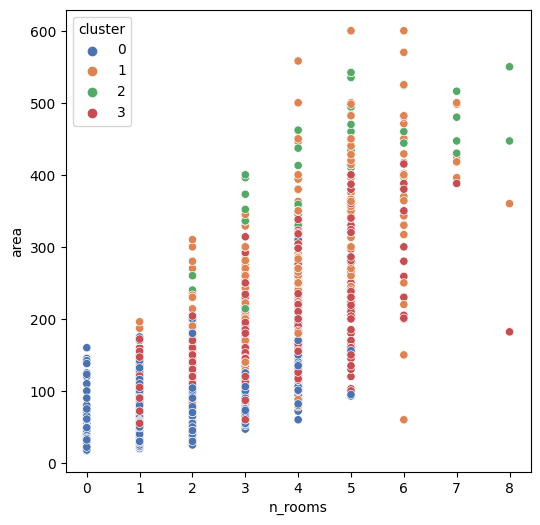

In [ ]:
# scatter

plt.figure(figsize=(6,6))
sns.scatterplot(x=df_limpio.n_rooms, y=df_limpio.area, hue=df_limpio.cluster, palette="deep")

### Guardar csv con columna cluster
* Cuando decidamos el nº de clústers guardamos en data/ no en data/raw

In [ ]:
# Guardar df final, para usar con los modelos

# df_limpio.to_csv('../data/df_limpio_clusters.csv') # con datos reales
# df.to_csv('../data/alquiler_clusters.csv') # con datos escalados

In [ ]:
dflimpio_clusters = pd.read_csv(r"C:\Users\axa\THE BRIDGE_23\SEMANA 25. DESAFIO TRIPULACIONES\df_limpio_clusters.csv", sep=",")

In [ ]:
dflimpio_clusters

,Unnamed: 0,area,local_price,latitud,longitud,tipology,n_rooms,n_baths,has_garage,has_pool,has_elevator,is_exterior,cluster
0,0,135,3200,40.437687,-3.691055,Piso,1.0,1.0,f,f,t,t,5
1,1,250,6000,40.439434,-3.686233,Piso,4.0,4.0,t,t,t,t,1
2,2,146,2460,40.468037,-3.708661,Piso,1.0,1.0,t,t,t,t,4
3,3,98,3000,40.441212,-3.670406,Piso,1.0,1.0,f,f,f,t,5
4,4,125,3675,40.411247,-3.668222,Piso,1.0,1.0,t,t,t,t,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,6345,45,1450,40.414158,-3.701161,Piso,1.0,1.0,f,f,f,f,0
6346,6346,30,1250,40.425045,-3.705386,Piso,1.0,1.0,f,f,f,f,0
6347,6347,73,900,40.392933,-3.736926,Piso,1.0,1.0,t,t,t,t,0
6348,6348,32,850,40.417221,-3.703297,Piso,0.0,1.0,f,f,t,t,0


<div id="map"></div>

<script>
    function initMap() {
        var map = new google.maps.Map(document.getElementById('map'), {
            center: {lat: 40.416775, lng: -3.703790}, // Centra el mapa en Madrid
            zoom: 12 // Nivel de zoom
        });

        // Agrega listener para capturar el evento de clic en el mapa. Chincheta
        google.maps.event.addListener(map, 'click', function(event) {
            // La variable "event" contiene las coordenadas (latitud y longitud) de la ubicación seleccionada
            var lat = event.latLng.lat();
            var lng = event.latLng.lng();
            // Puedes usar estas coordenadas en tu formulario
            document.getElementById('latitud').value = lat;
            document.getElementById('longitud').value = lng;
        });
    }
</script>


<script src="https://maps.googleapis.com/maps/api/js?key=YOUR_API_KEY&callback=initMap" async defer></script>